This notebook shows the training of various regression models with several versions of the dataset without any normalization or standardization of the features.

## Import libraries

In [1]:
from utils.sql_utils import extract_data_from_sql_db

import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('bmh')

import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error

# Decision tree-based algoritms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
SEED = 21

## Load data

In [4]:
filter_params = {
    'year': 2021,
    'month': 1,
    'property_type': 'apartment',
    'operation': 'rent'
}

df = extract_data_from_sql_db(**filter_params)

# Create new variables
df['balcony_area'] = df['total_area_m2'] - df['covered_area_m2']
df['has_balcony_yn'] = np.where(df['balcony_area']==0, 0, 1)

## Clean data

In [5]:
# Group comunas with very few properties in one category "Otra"
other_comunas = [
    'Cerro Navia',
    'Colina',
    'Conchalí',
    'El Bosque',
    'La Granja',
    'Lo Prado',
    'Maipú',
    'Pedro Aguirre Cerda',
    'Peñalolén',
    'Pudahuel',
    'Puente Alto',
    'Quilicura',
    'Renca',
    'San Bernardo',
    'San Ramón'
]

df['comuna'] = np.where(df['comuna'].isin(other_comunas), 'Other', df['comuna'])

for idx,row in df.iterrows():
    if df.loc[idx, 'comuna'] == 'Other':
        df.loc[idx, 'neighborhood'] = 'Other'

In [6]:
# Delete rows of comuna-bedroom categories which have less than 5 properties

rows_to_delete = []
for cat in df['bedrooms'].unique():
    data = df[df['bedrooms']==cat]
    count_series = data['comuna'].value_counts()
    comunas_to_delete = count_series[count_series < 5].index.tolist()
    idx_list = data[data['comuna'].isin(comunas_to_delete)].index.tolist()
    rows_to_delete.extend(idx_list)
    
df.drop(rows_to_delete, axis=0, inplace=True)

In [7]:
neighborhoods_list = [
    'Other',
    # Huechuraba
    'Pedro Fontova',
    'Bosques De La Pirámide',
    'Ciudad Empresarial',
    'Huechuraba',
    # La Reina
    'Blest Gana',
    'La Reina',
    'Metro Príncipe De Gales - Country Club',
    'Metro Simón Bolivar',
    'Carlos Ossandón',
    # San Joaquín
    'Rodrigo De Araya',
    'San Joaquín',
    'Carlos Valdovinos',
    'Metro San Joaquín',
    # La Cisterna
    'Lo Ovalle',
    'Metro La Cisterna',
    'La Cisterna',
    'El Parrón',
    # Quinta Normal
    'Gruta De Lourdes',
    'Quinta Normal',
    'Parque Padre Renato Poblete',
    'Blanqueado',
    'Salvador Gutiérrez',
    # Recoleta
    'Cerro Blanco',
    'Bellavista',
    'Recoleta',
    'Patronato',
    'Cementerios',
    # La Florida
    'Plaza Vespucio',
    'La Florida',
    'Vicente Valdés',
    'Metro Mirador',
    'La Florida Alto',
    'Rojas Magallanes',
    # Macul
    'Macul',
    'Metro Camino Agrícola',
    'Metro Las Torres',
    'Villa Macul',
    'Las Dalias',
    'Santa Julia De Macul',
    'Escuela Agrícola',
    'Metro Carlos Valdovinos',
    'Metro Macul',
    'Metro Quilín',
    'Metro Los Presidentes',
    # Lo Barnechea
    'La Dehesa',
    'Lo Barnechea',
    'Puente Nuevo',
    'Los Trapenses',
    'El Huinganal',
    'Plaza San Enrique',
    'Valle Escondido',
    # Independencia
    'Hospitales',
    'Plaza Chacabuco',
    'Independencia',
    'Juan Antonio Ríos',
    'Metro Cal Y Canto',
    # San Miguel
    'Lo Vial',
    'Ciudad Del Niño',
    'El Llano',
#     'San Miguel',
    # Estación Central
    'San Alberto Hurtado',
    'Metro Ecuador',
    'Metro Las Rejas',
    'Universidad De Santiago',
    # Vitacura
    'Parque Bicentenario',
    'Pío Xi',
    'Tabancura',
#     'Vitacura',
    'Jardín Del Este',
    'La Llavería',
    'Juan Xxiii',
    'Santa María De Manquehue',
    'Estadio Manquehue',
    'Borde Río - Casa Piedra',
    'Lo Curro',
    'Estadio Croata',
    'Nuestra Señora Del Rosario',
    'Villa El Dorado',
    # Ñuñoa
    'Metro Irarrázaval',
    'Plaza Ñuñoa',
    'Metro Monseñor Eyzaguirre',
    'Metro Ñuñoa',
    'Estadio Nacional',
    'Plaza Egaña',
    'Parque Juan Xxiii',
    'Parque San Eugenio - Metro Ñuble',
    'Diagonal Oriente',
    'Metro Simón Bolivar',
    'Juan Gómez Millas',
    'Villa Frei',
    'Diego De Almagro',
    'Parque Botánico',
    'Amapolas',
    # Providencia
    'Los Leones',
    'Las Lilas',
    'Pedro De Valdivia',
    'Manuel Montt',
    'Metro Tobalaba - Mall Costanera',
    'Salvador',
    'Inés De Suárez',
    'Barrio Italia',
    'Campus Oriente',
    'Plaza Italia',
    'Metro Bilbao',
    'Pedro De Valdivia Norte',
    'Bellavista',
    # Las Condes
    'Barrio El Golf',
    'Metro Escuela Militar',
    'Metro Manquehue - Apumanque',
    'Parque Arauco',
    'Centro Financiero',
    'Nueva Las Condes',
    'Metro Hernando De Magallanes',
    'Sebastián Elcano',
    'Alto Las Condes',
    'Vaticano',
    'Rotonda Atenas',
    'Mall Sport',
    'San Carlos De Apoquindo',
    'Los Dominicos',
    'Estoril',
    'San Damián',
    'Parque Padre Alberto Hurtado',
    'Colón Oriente - Vital Apoquindo',
    # Santiago
    'Centro Histórico De Santiago',
    'Santa Isabel',
    'Bulnes',
    'San Diego',
    'Parque Almagro',
    'Bogotá - Sierra Bella',
    "Parque O'Higgins",
    'Ejército - Toesca',
    'Barrio Diez De Julio',
    'Barrio Yungay',
    'Barrio Brasil',
    'Barrio República',
    'Barrio Lastarria',
    'Franklin - Biobío',
    'Parque Los Reyes',
    'Barrio San Borja'
]

In [8]:
to_delete = df[
    (df['neighborhood'].isin(neighborhoods_list)==False) |
    (df['balcony_area'] > 100) |
    (df['bathrooms'] > df['bedrooms'] + 1) |
    (df['bathrooms'] < df['bedrooms'] - 2) |
    ((df['bedrooms']==1) & (df['price'] > 2000000)) |
    ((df['bedrooms']==2) & (df['price'] > 3000000)) |
    ((df['comuna']=='Other') & (df['price'] >= 600000)) |
    ((df['comuna']=='La Cisterna') & (df['price'] >= 450000)) |
    ((df['comuna']=='Quinta Normal') & (df['price'] >= 500000)) |
    ((df['comuna']=='Recoleta') & (df['price'] > 800000)) |
    ((df['comuna']=='La Florida') & (df['price'] > 550000)) |
    ((df['comuna']=='Estación Central') & (df['price'] >= 500000)) |
    ((df['comuna']=='Ñuñoa') & (df['price'] >= 1000000)) |
    ((df['comuna']=='Providencia') & (df['price'] > 1500000)) |
    ((df['comuna']=='Santiago') & (df['price'] > 1000000))
].index.tolist()

df.drop(to_delete, axis=0, inplace=True)

In [9]:
df.head()

,price,bedrooms,bathrooms,covered_area_m2,total_area_m2,comuna,neighborhood,balcony_area,has_balcony_yn
0,523546,1,1,50,60,Las Condes,Barrio El Golf,10,1
1,550000,1,1,30,30,Las Condes,Barrio El Golf,0,0
2,400000,1,1,37,37,Las Condes,Barrio El Golf,0,0
3,465375,1,1,48,51,Las Condes,Barrio El Golf,3,1
4,450000,1,1,45,45,Las Condes,Barrio El Golf,0,0


## Check cleaned data

In [10]:
df[['price', 'covered_area_m2', 'total_area_m2']].describe().astype('int')

,price,covered_area_m2,total_area_m2
count,17939,17939,17939
mean,585101,68,74
std,469326,48,55
min,175000,16,16
25%,310000,38,40
50%,420000,50,54
75%,670000,80,86
max,4072028,500,600


In [11]:
df['comuna'] = df['comuna'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17939 entries, 0 to 18190
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   price            17939 non-null  int64   
 1   bedrooms         17939 non-null  int64   
 2   bathrooms        17939 non-null  int64   
 3   covered_area_m2  17939 non-null  int64   
 4   total_area_m2    17939 non-null  int64   
 5   comuna           17939 non-null  category
 6   neighborhood     17939 non-null  category
 7   balcony_area     17939 non-null  int64   
 8   has_balcony_yn   17939 non-null  int32   
dtypes: category(2), int32(1), int64(6)
memory usage: 1.1 MB


## Train machine learning models

In [13]:
ml_models = {
    # Decision tree-based algorithms
    'DecisionTree': DecisionTreeRegressor(random_state=SEED),
    'RandomForest': RandomForestRegressor(random_state=SEED, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=SEED),
    'Bagging': BaggingRegressor(random_state=SEED, n_jobs=-1),
    'ExtraTrees': ExtraTreesRegressor(random_state=SEED, n_jobs=-1),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=SEED),
    'XGBoost': XGBRegressor(use_label_encoder=False, eval_metric='mae', 
                            objective='reg:squarederror', 
                            random_state=SEED, n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=SEED, n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_seed=SEED, silent=True)
}

In [14]:
results = pd.DataFrame.from_dict({'model': ml_models.keys()})

In [15]:
TRAIN_SIZE = 0.80

features_list = [
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'comuna'], # dataset 01
    ['bedrooms', 'bathrooms', 'total_area_m2', 'comuna'], # dataset 02
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'total_area_m2', 'comuna'], # dataset 03
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'has_balcony_yn', 'comuna'], # dataset 04
    ['bedrooms', 'bathrooms', 'total_area_m2', 'has_balcony_yn', 'comuna'], # dataset 05
    ['bedrooms', 'bathrooms', 'covered_area_m2', 'balcony_area', 'comuna'], # dataset 06
    ['bedrooms', 'bathrooms', 'total_area_m2', 'balcony_area', 'comuna'] # dataset 07
]

for idx, features in enumerate(features_list):
    # Define features and target
    X = df[features]
    y = df['price']
    
    # Get dummy variables
    X = pd.get_dummies(X)
    
    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        train_size=TRAIN_SIZE, 
                                                        random_state=SEED)
    
    # 
    scores = []
    for key in ml_models:
        estimator = ml_models[key]
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        score = int(median_absolute_error(y_test, y_pred))
        scores.append(score)
    
    results['dataset_0{}'.format(idx + 1)] = scores

## Analyze results

In [16]:
results.set_index('model', inplace=True)
results

,dataset_01,dataset_02,dataset_03,dataset_04,dataset_05,dataset_06,dataset_07
model,,,,,,,
DecisionTree,42000,40439,42500,42787,42289,42500,42798
RandomForest,41577,40483,40452,41078,40889,40187,39923
GradientBoosting,46106,43291,43778,45128,43237,44308,43998
Bagging,42007,41318,41338,42214,41932,41790,41252
ExtraTrees,41627,40000,40471,41943,41250,40370,40000
HistGradientBoosting,43242,40536,41354,41712,40753,41197,40369
XGBoost,46301,43059,43209,44331,43553,43735,44280
LightGBM,42353,39937,40178,41707,39268,40825,40095
CatBoost,41931,40211,40256,40007,39907,39519,39611


In [17]:
results.mean().sort_values()

dataset_02    41030.444444
dataset_07    41369.555556
dataset_05    41453.111111
dataset_03    41504.000000
dataset_06    41603.444444
dataset_04    42323.000000
dataset_01    43016.000000
dtype: float64

In [18]:
results.mean().mean()

41757.079365079364

In [19]:
results.mean(axis=1).sort_values()

model
CatBoost                40206.000000
LightGBM                40623.285714
RandomForest            40655.571429
ExtraTrees              40808.714286
HistGradientBoosting    41309.000000
Bagging                 41693.000000
DecisionTree            42187.571429
XGBoost                 44066.857143
GradientBoosting        44263.714286
dtype: float64

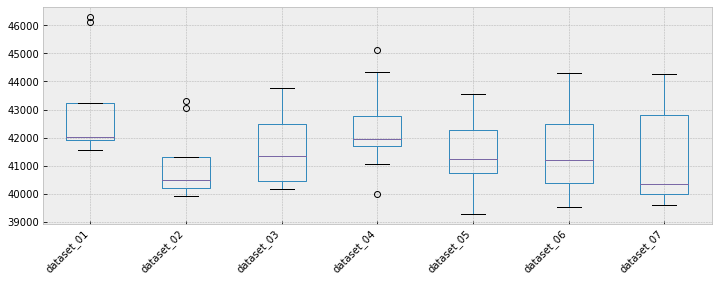

In [20]:
plt.figure(figsize=(12,4))
results.boxplot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [21]:
transposed_results = results.T
transposed_results

model,DecisionTree,RandomForest,GradientBoosting,Bagging,ExtraTrees,HistGradientBoosting,XGBoost,LightGBM,CatBoost
dataset_01,42000,41577,46106,42007,41627,43242,46301,42353,41931
dataset_02,40439,40483,43291,41318,40000,40536,43059,39937,40211
dataset_03,42500,40452,43778,41338,40471,41354,43209,40178,40256
dataset_04,42787,41078,45128,42214,41943,41712,44331,41707,40007
dataset_05,42289,40889,43237,41932,41250,40753,43553,39268,39907
dataset_06,42500,40187,44308,41790,40370,41197,43735,40825,39519
dataset_07,42798,39923,43998,41252,40000,40369,44280,40095,39611


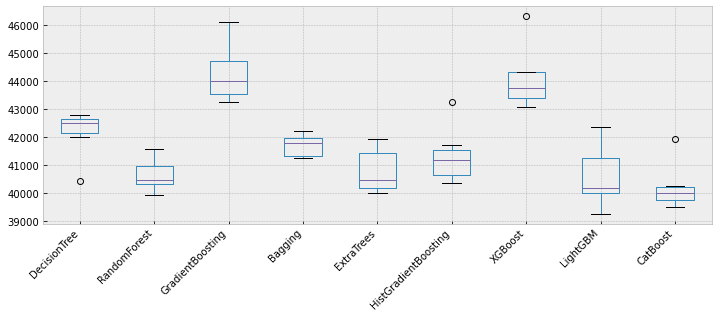

In [22]:
plt.figure(figsize=(12,4))
transposed_results.boxplot()
plt.xticks(rotation=45, ha='right')
plt.show()